In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats.stats import pearsonr
import itertools
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from xgboost import plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn import svm
import Helper_Func as H

In [2]:
pd.options.display.max_rows = 410
pd.options.display.max_columns = 40

## Data Loading and Cleaning

We are interested in predicting whether a credit loan would be charged off given other attributes of the loan.

For data cleaning, we start with only considering loans that are either fully paid or charged off, since we do not know the future state of a loan in the process of being paid off or charged off. 

We notice that many columns are dense with missing values. We choose to drop all columns that consists of more than 90% missing values, and we further choose to drop all rows containing missing values, which is around 20% of all observations. We then would drop all the columns that satisfy at least one of the following criteria:  
    - Contains post-origination information  
    - Obviously does not relate to charge off information (e.g., ID)  
    - Is a categorical column containing many categories (greater than 50)  
    - Has a Pearson correlation of over 60%  
    
We apply transformations to the covariates to fit them into a standard normal distribution. These include log, square root, and cube root.

We then apply one-hot/dummy encoding to the categorical columns, dropping one column of each to avoid multicollinearity. We are left with a dataframe of 1090611 observations and 62 covariates plus the outcome variable.

See Helper_Func.py for the data cleaning function.

In [3]:
data = pd.read_csv("accepted_2007_to_2018Q4.csv")

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
cleaned_data = H.CleanData(data)

In [5]:
cleaned_data.shape

(1090611, 63)

# Regression Analysis

Our first approach is logistic regression. We first run individual logistic regressions of loan_status against each covariate separately. We then select 53 out of 62 covariates with the greatest significance, indicated by the magnitude of the t-statistic, for a multiple logistic regression. Many of the coefficients of the most significant variables agree with intuition. For instance, borrowers with higher annual income or FICO score are less likely to default on their loan, while borrowers who take out larger loans are more likely to default.

In [6]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [7]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [8]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [9]:
# Write a function to perform the logistic regression
# Inputs: 
#    X: 2D array
#    y: Charged Off variable (1d array)
# Output: [coefficient, t-value]

def regress_log(X, y):
    
    log_reg = sm.Logit(np.asarray(y), X).fit(disp=0)
    
    return [log_reg.params, log_reg.t_test('x1=0').tvalue]

In [10]:
names_list = cleaned_data.columns[0:len(cleaned_data.columns) - 1]

In [11]:
# Initialize results dataframe
reg_results = pd.DataFrame(np.zeros((len(names_list), 3)))
reg_results[0] = names_list
reg_results = reg_results.set_axis(['name','coef','t-stat'], axis = 1)

In [12]:
# Loop the regression over all variable names
for i in range(len(names_list)):
    X = np.array(X_train[names_list[i]]).reshape(-1,1)
    results = regress_log(X, y_train)
    
    reg_results['coef'][i] = results[0][0]
    reg_results['t-stat'][i] = np.abs(results[1][0])

<ipython-input-12-b6e889e3f2b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['coef'][i] = results[0][0]
<ipython-input-12-b6e889e3f2b5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results['t-stat'][i] = np.abs(results[1][0])
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [13]:
reg_results.head()

,name,coef,t-stat
0,loan_amnt,0.118067,54.919182
1,annual_inc,-0.098705,45.882366
2,dti,0.157289,72.485142
3,delinq_2yrs,0.029353,13.701852
4,fico_range_low,-0.203322,93.704637


In [14]:
# Order the results by t-statistic
sorted_results = reg_results.sort_values(by = 't-stat', axis = 0, ascending = False)

top53 = sorted_results.head(53)
top53.head(10)

,name,coef,t-stat
60,initial_list_status_w,-1.435545,413.621307
40,home_ownership_MORTGAGE,-1.615845,398.502240
48,purpose_debt_consolidation,-1.359522,392.943499
45,verification_status_Source Verified,-1.348237,328.848404
30,emp_length_10+ years,-1.490514,320.710706
44,home_ownership_RENT,-1.228064,300.784721
47,purpose_credit_card,-1.646349,266.390589
46,verification_status_Verified,-1.207383,251.200522
43,home_ownership_OWN,-1.415489,168.422180
29,term_ 60 months,-0.761320,165.921210


In [15]:
names_53 = top53['name']

## Multiple Logistic Regression

We fit a multiple logistic regression model using the aforementioned 53 covariates on the training set, then predict loan_status for the test set. One issue we ran into here was that including 54 or more covariates would result in a singular matrix. We address this later by using ridge regression.  

The predictions give probabilities of default, which are between 0 and 1. In order to convert these probabilities to binary predictions, we use the receiver operating characteristic (ROC) curve to find the optimal probability threshold at which a loan should be predicted to default. In this case, the optimal threshold is 0.18702.  

From our predictions, we obtain a balanced accuracy score of 0.65122. We use the balanced accuracy score since the outcome variable, loan_status is unevenly split between the two categories - about 80% fully paid and 20% defaulted loans. The balanced accuracy formula rebalances the score to be between 0.5 and 1.

In [16]:
top_names = list(sorted_results.iloc[0:53]['name'].values)

In [17]:
#Using 53 covariates
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)

In [18]:
#Find optimal ROC cutoff
y_pred = log_reg_mult.predict(X_valid[top_names])

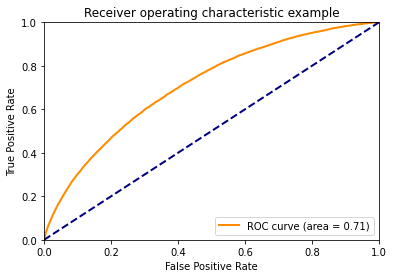

Optimal Threshold: 0.18701962144750753


[array([1.83732878, 0.83732878, 0.81747434, ..., 0.01289546, 0.01288991,
        0.00632105]),
 18867]

In [19]:
H.ROC_cutoff(y_pred, y_valid)

In [20]:
# Get some accuracy metrics
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= 0.1870196214475139).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

In [21]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.6512199908122926
Log Reg F1: 0.4159850084773491
Log Reg Recall: 0.6694911197280865


In [22]:
print(log_reg_mult.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               872488
Model:                          Logit   Df Residuals:                   872435
Method:                           MLE   Df Model:                           52
Date:                Mon, 04 Apr 2022   Pseudo R-squ.:                 0.09008
Time:                        22:04:58   Log-Likelihood:            -3.8907e+05
converged:                       True   LL-Null:                   -4.2759e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
initial_list_status_w                   0.0044      0.006      0.730      0.466      -0.007       0.016
home_ownership_MORTGAGE                -1.9719      0.03

## Multiple Logistic Regression With Interactions

Next, we explore the possibility of interactions within our data. In order to determine which interaction terms to include, we find the correlation between each pair of covariates and select the pairs with the highest magnitude of correlation. Our reasoning is that the more related two variables are, the more likely they are to have an underlying interaction.  

After including the interaction terms, we see a marginal increase in the balanced accuracy score to 0.65309 (previously 0.65122). 

In [23]:
def corr_analysis(data):
    correlations = {}
    names_list = data.columns[0:len(data.columns) - 1]
    for col_a, col_b in itertools.combinations(names_list, 2):
        correlations[col_a + '__' + col_b] = pearsonr(data.loc[:, col_a], data.loc[:, col_b])

    corr_result = pd.DataFrame.from_dict(correlations, orient='index')
    corr_result.columns = ['PCC', 'p-value']
    corr_result['abs_PCC'] = np.abs(corr_result['PCC'])
    top_20 = corr_result.sort_values('abs_PCC', ascending=False).head(20)
    return(top_20)

In [24]:
corr_result = corr_analysis(X_train[names_53])
# Drop the interactions between pairs from the same categorical column, as they would be all 0.
corr_result = corr_result.drop(['home_ownership_MORTGAGE__home_ownership_RENT',
                                'purpose_debt_consolidation__purpose_credit_card',
                                'verification_status_Source Verified__verification_status_Verified'], axis=0)
corr_result

,PCC,p-value,abs_PCC
mort_acc__tot_cur_bal,0.637524,0.0,0.637524
home_ownership_MORTGAGE__tot_cur_bal,0.586099,0.0,0.586099
home_ownership_MORTGAGE__mort_acc,0.581781,0.0,0.581781
acc_open_past_24mths__mo_sin_rcnt_tl,-0.574404,0.0,0.574404
home_ownership_RENT__mort_acc,-0.559912,0.0,0.559912
home_ownership_RENT__tot_cur_bal,-0.555346,0.0,0.555346
tot_cur_bal__total_bal_ex_mort,0.541504,0.0,0.541504
total_bc_limit__num_bc_tl,0.532175,0.0,0.532175
tot_cur_bal__annual_inc,0.521186,0.0,0.521186
mo_sin_rcnt_tl__mths_since_recent_bc,0.510115,0.0,0.510115


In [25]:
corr_names = list(corr_result.index)

In [26]:
# Create the interaction terms
for i in corr_names:
    two_names = i.split(sep = "__")
    X_train[i] = X_train[two_names[0]] * X_train[two_names[1]]
    X_test[i] = X_test[two_names[0]] * X_test[two_names[1]]
    X_valid[i] = X_valid[two_names[0]] * X_valid[two_names[1]]

In [27]:
#Some custom interactions we thought might have value
X_train['loan_amnt__fico_range_low'] = X_train['loan_amnt'] * X_train['fico_range_low']
X_test['loan_amnt__fico_range_low'] = X_test['loan_amnt'] * X_test['fico_range_low']
X_valid['loan_amnt__fico_range_low'] = X_valid['loan_amnt'] * X_valid['fico_range_low']
X_train['dti__fico_range_low'] = X_train['dti'] * X_train['fico_range_low']
X_test['dti__fico_range_low'] = X_test['dti'] * X_test['fico_range_low']
X_valid['dti__fico_range_low'] = X_valid['dti'] * X_valid['fico_range_low']


In [28]:
top_names = list(sorted_results.iloc[0:53]['name'].values)
top_names = np.append(top_names,corr_names)
manual_names = ['loan_amnt__fico_range_low','dti__fico_range_low']
top_names = np.append(top_names,manual_names)

In [29]:
#Using 53 covariates plus interaction terms
log_reg_mult = sm.Logit(np.asarray(y_train), X_train[top_names]).fit(disp=0)

In [30]:
#Find optimal ROC cutoff
y_pred = log_reg_mult.predict(X_valid[top_names])

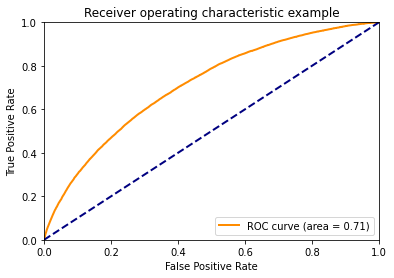

Optimal Threshold: 0.18973962194363958


[array([1.83366956, 0.83366956, 0.83085731, ..., 0.01583668, 0.01583204,
        0.00694998]),
 18343]

In [31]:
H.ROC_cutoff(y_pred, y_valid)

In [32]:
# Accuracy metrics
log_reg_preds = (log_reg_mult.predict(X_test[top_names]) >= 0.193204696).astype(int)
log_reg_BA = balanced_accuracy_score(y_test, log_reg_preds)
log_reg_recal = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[1,0])
log_reg_prec = confusion_matrix(y_test, log_reg_preds)[1,1]/(confusion_matrix(y_test, log_reg_preds)[1,1]+confusion_matrix(y_test, log_reg_preds)[0,1])
log_reg_F1 = 2 * log_reg_prec * log_reg_recal/(log_reg_prec+log_reg_recal)

In [33]:
print('Log Reg Balanced Accuracy:',log_reg_BA)
print('Log Reg F1:',log_reg_F1)
print('Log Reg Recall:',log_reg_recal)

Log Reg Balanced Accuracy: 0.653094121646493
Log Reg F1: 0.4192073641614926
Log Reg Recall: 0.6496720762123606


In [34]:
print(log_reg_mult.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               872488
Model:                          Logit   Df Residuals:                   872416
Method:                           MLE   Df Model:                           71
Date:                Mon, 04 Apr 2022   Pseudo R-squ.:                 0.09095
Time:                        22:07:29   Log-Likelihood:            -3.8870e+05
converged:                       True   LL-Null:                   -4.2759e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
initial_list_status_w                          0.0024      0.006      0.398      0.691      -0.009       0.014
home_ownership_MORTGAGE            

# Ridge Regression

Due to issues with multicollinearity, we tried ridge regression along with standard logistic regression to adjust for  the design matrix which is almost singular.  

We obtain a balanced accuracy score of 0.65364, which slightly improves upon our multiple logistic model with interactions (0.65309).

In [35]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [36]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

## Parameter Fitting Code

In [37]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.05, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [38]:
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [39]:
def RidgeModelCV(X_train, y_train, X_valid, y_valid, alphas, weights):

    #with parallel_backend('threading', n_jobs=8):

        #10-fold Cross Validation to select the optimal penalty hyperparameter.
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

        #Setting up model with sklearn using the penalty score obtained.
        #ridge_reg = RidgeClassifierCV(alphas=arange(1, 5, 0.1), cv=cv, scoring='neg_mean_absolute_error')

    BA_scores = np.zeros((len(alphas),len(weights)))
    rec_scores = np.zeros((len(alphas),len(weights)))
                          
    #Initialize our for loop to iterate through alpha values
    for i in range(len(alphas)):
        for j in range(len(weights)):
            ridge_reg = RidgeClassifier(alpha=alphas[i],class_weight={0:1,1:weights[j]})

            #Train the model.
            ridge_reg.fit(X_train, y_train)

            #Use the model to make prediction scores.
            ridge_reg_preds = ridge_reg._predict_proba_lr(X_valid)
            ridge_reg_preds = ridge_reg_preds[:,1]
            
            
            #Calculate ideal probability thresholds for each lambda
            ridge_reg_thresh = H.ROC_cutoff(ridge_reg_preds,y_valid, silence=True)
            temp1 = ridge_reg_thresh[0]
            temp2 = ridge_reg_thresh[1]
            ridge_reg_thresh = temp1[temp2]
            

            ridge_reg_preds = (ridge_reg_preds >= ridge_reg_thresh).astype(int)

            #Calculate balanced accuracy.
            BA_scores[i][j] = balanced_accuracy_score(y_valid, ridge_reg_preds)
            rec_scores[i][j] = confusion_matrix(y_valid, ridge_reg_preds)[1,1]/(confusion_matrix(y_valid, ridge_reg_preds)[1,1]+confusion_matrix(y_valid, ridge_reg_preds)[1,0])              

    #Check if logistic.
    best_alpha = alphas[np.argmax(np.max(BA_scores, axis=1))]
    best_weight = weights[np.argmax(np.max(BA_scores, axis=0))]

    return(best_alpha,best_weight)

In [40]:
alphas = np.arange(0, 5, 0.25)
weights = np.array([1,3,5])
best_alpha,best_weight = RidgeModelCV(X_train, y_train, X_valid, y_valid, alphas, weights)

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [41]:
print("Best Alpha:",best_alpha)
print("Best Weight:",best_weight)

Best Alpha: 0.0
Best Weight: 5


## Full Data Set Prediction

In [42]:
#Running Ridge Reg on full dataset on optimized hyperparameters
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

ridge_reg = RidgeClassifier(alpha=best_alpha,class_weight={0:1,1:best_weight})

#Train the model.
ridge_reg.fit(X_train, y_train)

#Use the model to make prediction scores.
ridge_reg_preds = ridge_reg._predict_proba_lr(X_test)
ridge_reg_preds = ridge_reg_preds[:,1]

#Calculate ideal probability thresholds for each lambda
ridge_reg_thresh = H.ROC_cutoff(ridge_reg_preds,y_test, silence=True)
temp1 = ridge_reg_thresh[0]
temp2 = ridge_reg_thresh[1]
ridge_reg_thresh = temp1[temp2]
            

ridge_reg_preds = (ridge_reg_preds >= ridge_reg_thresh).astype(int)

#Calculate balanced accuracy.
print("Balanced Accuracy:",balanced_accuracy_score(y_test, ridge_reg_preds))

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RidgeClassifier(alpha=0.0, class_weight={0: 1, 1: 5})

Balanced Accuracy: 0.6536486257215158


## XGBoost

Due to the large number of covariates and our suspicion of non-linear relationships and collinearity within the data, we also wanted to try more advanced machine learning models. Our first approach is XGBoost (extreme gradient boosting) due to its performance on large data sets and data with outliers.

In [43]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [44]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

## Parameter Fitting Code

This does not need to be run. Note that this code is time consuming.  

XGBoost has two main parameters that require tuning: max_depth and eta. We perform a grid search to find the best values for each, which turn out to be max_depth = 2 and eta = 0.3.

In [ ]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.05, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [ ]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [ ]:
# Code for parameter fitting
# May take a while to run
accur = [0]*100
FN = [0]*100
FP = [0]*100
F1 = [0]*100
prec = [0]*100
recal = [0]*100
BA = [0]*100
for i in range(1,11):
    for j in range(1,11):
        xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=i,eta=0.1*j,gamma=0)
        model = xgb_cl.fit(X_train,y_train)
        xgb_val = model.predict_proba(X_valid)[:,1]
        ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
        thresholds = ROC[0]
        threshold = thresholds[ROC[1]]
        preds = (xgb_val >= threshold).astype(int)
        BA[10*(i-1)+(j-1)] = balanced_accuracy_score(y_valid, preds)

In [ ]:
#BA.index(max(BA))
#max(BA)
eta = int(BA.index(max(BA)) % 10 + 1)
max_depth = int((BA.index(max(BA))-(eta-1))/10)+1
print("Optimum Max Depth:",max_depth)
print("Optimum Eta:",eta/10)

## Full Data Set Prediction

In [45]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [46]:
# Set up statified data
X_train= trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

In [47]:
# Fitting the full model - this may take several minutes
xgb_cl = xgb.XGBClassifier(use_label_encoder=False,booster='gbtree',verbosity=0,max_depth=2,eta=0.3,gamma=0)
model = xgb_cl.fit(X_train,y_train)

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [48]:
#ROC cutoff
xgb_val = model.predict_proba(X_valid)[:,1]
ROC=H.ROC_cutoff(xgb_val,y_valid, silence = True)
thresholds = ROC[0]
threshold = thresholds[ROC[1]]

In [49]:
#Check Model Accuracy
xgb_preds = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
xgb_prec = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[0,1])
xgb_recal = confusion_matrix(y_test, xgb_preds)[1,1]/(confusion_matrix(y_test, xgb_preds)[1,1]+confusion_matrix(y_test, xgb_preds)[1,0])
xgb_F1 = 2 * xgb_prec * xgb_recal/(xgb_prec+xgb_recal)
xgb_BA = balanced_accuracy_score(y_test, xgb_preds)

In [50]:
print('XGB Balanced Accuracy:',xgb_BA)
print('XGB F1:',xgb_F1)
print('XGB Recall:',xgb_recal)

XGB Balanced Accuracy: 0.6575986835992438
XGB F1: 0.4235712206853239
XGB Recall: 0.6618794580879889


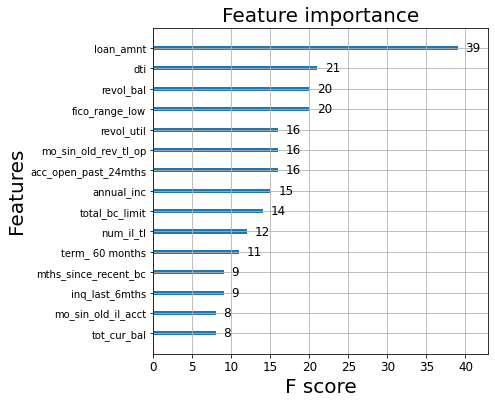

In [51]:
#Feature Importance
params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 10}
ax = plt.rcParams.update(params)
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model,max_num_features=15,ax=ax)

## Support Vector Machine (SVM)

We also applied a support vector machine (SVM) model. However due to the non-linear verisons uninterprebility we only experimented with linear SVM. In addition, training SVMs becomes extremely computationally expensive for larger datasets, so we train the data on a sample of 5% of the original training set.

In [52]:
splitdata=H.DataSplit(cleaned_data,0.1,0.1,seed=0)

In [53]:
trainingdata = splitdata[0]
validationdata = splitdata[1]
testdata = splitdata[2]

In [54]:
# Used when fitting parameters
# Cutting down training data size
trainingdata = trainingdata.sample(frac=0.01, replace=False, random_state=1)
validationdata =  validationdata.sample(frac=1, replace=False, random_state=1)
testdata =  testdata.sample(frac=1, replace=False, random_state=1)

In [55]:
# Set up statified data
X_train = trainingdata.drop(["loan_status"],axis=1)
y_train = trainingdata[["loan_status"]]
X_test = testdata.drop(["loan_status"],axis=1)
y_test = testdata[["loan_status"]]
X_valid = validationdata.drop(["loan_status"],axis=1)
y_valid = validationdata[["loan_status"]]

## Parameter Fitting Code

This does not need to be run. Note that this code is time consuming.

We perform a grid search to find the best values for C and Class_Score, which turn out to be C = 0.01 and Class_Score = 5.


In [ ]:
# Warning: This may take around half an hour to run
from statistics import mean
# With cross validation
k = 10
rng = np.random.default_rng(1) #setting the seed - for reproducability
shuffle = rng.choice(len(X_train), size=len(X_train), replace=False)
C = [10**-2,10**-1,0.5,1]
Class_Score = [4,5,6]
#C = [1,2]
#Class_Score = [1,2]

BA_scores = np.zeros((len(C),len(Class_Score)))
rec_scores = np.zeros((len(C),len(Class_Score)))

for c in range(len(C)):
    for s in range(len(Class_Score)):
        val_BA_list = []
        val_rec_list = []
        for i in range(k):
            svm_train_rows = shuffle[i:(i+1)*round(len(X_train)/k)]

            svm_X_train = X_train.iloc[svm_train_rows]
            svm_y_train = y_train.iloc[svm_train_rows]

            clf = svm.LinearSVC(C = C[c],class_weight={0:1,1:Class_Score[s]})
            clf.fit(svm_X_train,np.ravel(svm_y_train))
            svm_preds = clf.predict(X_valid)
            val_BA_list.append(balanced_accuracy_score(y_valid, svm_preds))
            val_rec_list.append(confusion_matrix(y_valid, svm_preds)[1,1]/(confusion_matrix(y_valid, svm_preds)[1,1]+confusion_matrix(y_valid, svm_preds)[1,0]))
        #print(c, mean(val_BA_list), mean(val_rec_list))
        BA_scores[c][s] = mean(val_BA_list)
        rec_scores[c][s] = mean(val_rec_list)

In [ ]:
print(BA_scores)
print(rec_scores)

In [ ]:
# SPAM scores plot
params = {'axes.labelsize': 10,'axes.titlesize':20, 'font.size': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10}
for i in range(len(Class_Score)):
    ax = plt.rcParams.update(params)
    ax = plt.figure(figsize=(6,6))
    ax = plt.scatter(range(len(rec_scores[:,i])),BA_scores[:,i])
    ax = plt.scatter(range(len(rec_scores[:,i])),rec_scores[:,i])
    ax = plt.plot(range(len(rec_scores[:,i])),BA_scores[:,i],label = "Balanced Accuracy Scores")
    ax = plt.plot(range(len(rec_scores[:,i])),rec_scores[:,i],label = "Recall Scores")
    ax = plt.title("SVM CV Scores (Class Score = " + str(Class_Score[i]) + ")")
    ax = plt.xlabel("Number of Data Points (C = [10^-2,10^-1,0.5,1])")
    ax = plt.ylabel("Scores")
    ax = plt.legend()
    plt.show()

In [56]:
# best_C = C[np.argmax(np.max(BA_scores, axis=1))]
# best_Class_Score = Class_Score[np.argmax(np.max(BA_scores, axis=0))]
best_C = 0.01
best_Class_Score = 5
print("Best C:", best_C)
print("Best Class Score:", best_Class_Score)

Best C: 0.01
Best Class Score: 5


## Full Data Set Prediction

In [57]:
clf = svm.LinearSVC(C = best_C,class_weight={0:1,1:best_Class_Score})
clf.fit(X_train,np.ravel(y_train))
svm_preds = clf.predict(X_test)

print("acc", accuracy_score(y_test, svm_preds))
print("FN", confusion_matrix(y_test, svm_preds)[1,0])
print("FP", confusion_matrix(y_test, svm_preds)[0,1])
print("prec", confusion_matrix(y_test, svm_preds)[1,1]/(confusion_matrix(y_test, svm_preds)[1,1]+confusion_matrix(y_test, svm_preds)[0,1]))
print("rec", confusion_matrix(y_test, svm_preds)[1,1]/(confusion_matrix(y_test, svm_preds)[1,1]+confusion_matrix(y_test, svm_preds)[1,0]))
#print("F1", 2 * prec[i-1] * recal[i-1]/(prec[i-1]+recal[i-1]))
print("BA", balanced_accuracy_score(y_test, svm_preds))

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=0.01, class_weight={0: 1, 1: 5})

acc 0.6143661403605288
FN 6228
FP 35830
prec 0.29036858053910597
rec 0.7018526497199483
BA 0.6477462130343585


## SVM Coefficient Importance Plot

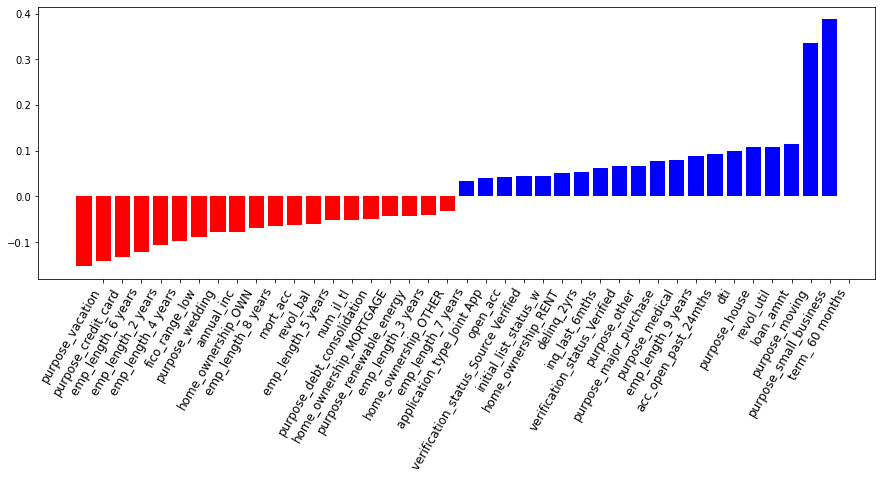

In [58]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red'if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
plot_coefficients(clf, X_train.columns)

We obtain a maximum balanced accuracy score of 0.64775, which is lower than our previous models. The SVM model assigns importance to features differently from previous models, but certain features remain similarly important, such as FICO score, annual income, dti, and loan amount.